## Train the model

In this notebook, we build the model and train it. 
We use transfer learning.we reuse a pre-trained model as the starting point for a model on a new task. 
Transfer learning is a technique by which we can use the model weights trained on standard datasets such as ImageNet
to improve the efficiency of our given task.

We use transfer learning because we have less data points, it is fast as we need not train from scratch and it's accurate. 
We are using state of art!!!

we’ll be using VGG-1, ResNet, alexnet, squeezenet, googlenet and inceprion. 
Based on their initial performance, we decide to go further with vgg11 to to classify our dataset. 
VGG-11 mainly has three parts: convolution, Pooling, and fully connected layers.that is :
        
a. 8 Convolution layer- In this layer, filters are applied to extract features from images. The most important parameters are the size of the kernel and stride.  

b. Pooling layer- Its function is to reduce the spatial size to reduce the number of parameters and computation in a network.  

c. 3 Fully Connected- These are fully connected connections to the previous layers as in a simple neural network.

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

In [5]:
BASE_DIR = '..'
RANDOM_SEED = 7 # for reproducibility
COUNTRIES_DIR = os.path.join(BASE_DIR, 'gdelt')
PROCESSED_DIR = os.path.join(BASE_DIR, 'data', 'processed')

# these relate to training the CNN to predict nightlights
CNN_TRAIN_IMAGE_DIR = os.path.join(BASE_DIR, 'data', 'cnn_images')
CNN_SAVE_DIR = os.path.join(BASE_DIR, 'models')


In [6]:
os.makedirs(CNN_TRAIN_IMAGE_DIR, exist_ok=True)
os.makedirs(CNN_SAVE_DIR, exist_ok=True)

# Preprocess the image
After doing this once, you can skip to the training if the script broke

In [52]:
df_download = pd.read_csv(os.path.join(PROCESSED_DIR, 'nightimage_download_locs.csv'))
downloaded = os.listdir(os.path.join(COUNTRIES_DIR, 'images')) 

print(f"actually downloaded: {len(downloaded)}, expected: {len(df_download)}")

actually downloaded: 801, expected: 801


In [53]:
df_download1 = pd.read_csv(os.path.join(PROCESSED_DIR, 'nightimage_download_locs.csv'))

In [54]:
df_download.head()

,image_name,image_lat,image_lon,cluster_lat,cluster_lon,consumervalue,agvalue,elevationvalue,mblphne,pop15_49,electricityvalue,pop0_5,nightlights,Noofprotest,nightlights_bin
0,28.09281738863522_85.33364738863521_28.12875_8...,28.092817,85.333647,28.12875,85.36958,0.274684,0.95135,2541.405,0.898354,13.999999,0.918342,2.0,0.0,3.0,0
1,28.12875_85.33364738863521_28.12875_85.36958.png,28.128750,85.333647,28.12875,85.36958,0.274684,0.95135,2541.405,0.898354,13.999999,0.918342,2.0,0.0,3.0,0
2,28.164682611364782_85.33364738863521_28.12875_...,28.164683,85.333647,28.12875,85.36958,0.274684,0.95135,2541.405,0.898354,13.999999,0.918342,2.0,0.0,3.0,0
3,28.09281738863522_85.36958_28.12875_85.36958.png,28.092817,85.369580,28.12875,85.36958,0.274684,0.95135,2541.405,0.898354,13.999999,0.918342,2.0,0.0,3.0,0
4,28.12875_85.36958_28.12875_85.36958.png,28.128750,85.369580,28.12875,85.36958,0.274684,0.95135,2541.405,0.898354,13.999999,0.918342,2.0,0.0,3.0,0


In [55]:
df_download1.describe()

,image_lat,image_lon,cluster_lat,cluster_lon,consumervalue,agvalue,elevationvalue,mblphne,pop15_49,electricityvalue,pop0_5,nightlights,Noofprotest,nightlights_bin
count,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000
mean,27.584649,85.277261,27.584649,85.277261,0.643054,0.714348,1099.611175,0.950683,1859.337122,0.949801,253.662928,10.784730,218.000000,0.910112
std,0.314269,0.263780,0.312895,0.262141,0.220095,0.166020,652.220397,0.105149,4213.356748,0.106710,534.064925,16.050330,619.836192,0.870006
min,26.801151,84.583647,26.837084,84.619580,0.090941,0.411820,52.422500,0.000000,13.999999,0.000000,2.000000,0.000000,1.000000,0.000000
25%,27.501150,85.152916,27.537083,85.152916,0.460698,0.603601,459.999820,0.949893,88.000000,0.946223,17.999998,0.000000,12.000000,0.000000
50%,27.664683,85.316977,27.662083,85.319580,0.671920,0.715111,1318.371800,0.964112,207.000000,0.968325,34.000004,5.292453,31.000000,1.000000
75%,27.773016,85.405513,27.762083,85.394585,0.843840,0.870661,1452.603300,0.980196,1281.999900,0.985674,196.000000,13.407218,111.000000,2.000000
max,28.164683,85.872183,28.128750,85.836250,0.955629,0.983011,2541.405000,0.999553,24019.000000,1.000000,2978.000000,59.707546,5000.000000,2.000000


In [56]:
type(downloaded)

list

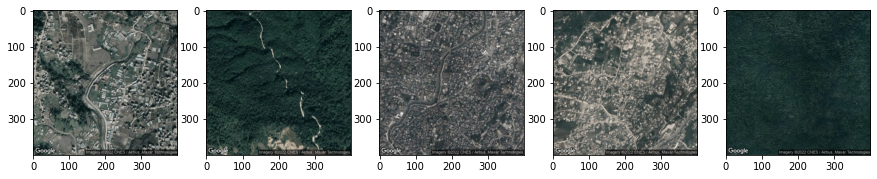

In [57]:
import matplotlib.pyplot as plt
import matplotlib.image as img
train_path = ('../gdelt/images/')
fig,ax = plt.subplots(1,5,figsize = (15,3))

for i,idx in enumerate(df_download[df_download['nightlights_bin'] ==2]['image_name'][1:6]):
    path = os.path.join(train_path,idx)
    ax[i].imshow(img.imread(path))

In [58]:
df_download['image_name'][0]

'28.09281738863522_85.33364738863521_28.12875_85.36958.png'

In [59]:
df_download['row'] = np.arange(len(df_download))

In [60]:
idx_not_download = df_download.set_index('image_name').drop(downloaded)['row'].values.tolist()
df_download.drop(idx_not_download, inplace=True)

In [61]:
df_download.drop('row', axis=1, inplace=True)

In [62]:
df_download.shape

(801, 15)

In [63]:
# the distribution
#(df_download['consumer_bin']==0).mean(), (df_download['consumer_bin']==1).mean(), (df_download['consumer_bin']==2).mean()
(df_download['nightlights_bin']==0).mean(), (df_download['nightlights_bin']==1).mean(), (df_download['nightlights_bin']==2).mean()


(0.42696629213483145, 0.23595505617977527, 0.33707865168539325)

Split images into train/valid.
Each cluster will contribute 80% of images for training, and 20% for validation.

In [64]:
df_download.reset_index(drop=True, inplace=True)

In [65]:
df_download.head()

,image_name,image_lat,image_lon,cluster_lat,cluster_lon,consumervalue,agvalue,elevationvalue,mblphne,pop15_49,electricityvalue,pop0_5,nightlights,Noofprotest,nightlights_bin
0,28.09281738863522_85.33364738863521_28.12875_8...,28.092817,85.333647,28.12875,85.36958,0.274684,0.95135,2541.405,0.898354,13.999999,0.918342,2.0,0.0,3.0,0
1,28.12875_85.33364738863521_28.12875_85.36958.png,28.128750,85.333647,28.12875,85.36958,0.274684,0.95135,2541.405,0.898354,13.999999,0.918342,2.0,0.0,3.0,0
2,28.164682611364782_85.33364738863521_28.12875_...,28.164683,85.333647,28.12875,85.36958,0.274684,0.95135,2541.405,0.898354,13.999999,0.918342,2.0,0.0,3.0,0
3,28.09281738863522_85.36958_28.12875_85.36958.png,28.092817,85.369580,28.12875,85.36958,0.274684,0.95135,2541.405,0.898354,13.999999,0.918342,2.0,0.0,3.0,0
4,28.12875_85.36958_28.12875_85.36958.png,28.128750,85.369580,28.12875,85.36958,0.274684,0.95135,2541.405,0.898354,13.999999,0.918342,2.0,0.0,3.0,0


In [66]:
df_download.shape

(801, 15)

In [67]:
df_download['is_train'] = True

In [68]:
np.random.seed(RANDOM_SEED)
groups = df_download.groupby(['cluster_lat', 'cluster_lon'])
for _, g in groups:
    n_ims = len(g)
    n_train = int(0.8 * n_ims)
    n_valid = n_ims - n_train
    valid_choices = np.random.choice(np.arange(n_ims), replace=False, size=n_valid).tolist()
    current_index = g.index
    idx_valid = current_index[valid_choices]
    df_download['is_train'].loc[idx_valid] = False

/home/samal/poudelnish/.conda/envs/aanisha/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [69]:
df_download['is_train'].mean()

0.7777777777777778

In [70]:
# save this new dataframe
df_download.to_csv(os.path.join(PROCESSED_DIR, 'nightimage_download_actual.csv'), index=False)

In [71]:
os.makedirs(os.path.join(CNN_TRAIN_IMAGE_DIR, 'train'), exist_ok=False)
os.makedirs(os.path.join(CNN_TRAIN_IMAGE_DIR, 'valid'), exist_ok=False)

labels = ['0', '1', '2']
for l in labels:
    os.makedirs(os.path.join(CNN_TRAIN_IMAGE_DIR, 'train', l), exist_ok=False)
    os.makedirs(os.path.join(CNN_TRAIN_IMAGE_DIR, 'valid', l), exist_ok=False)

In [72]:
t = df_download[df_download['is_train']]
v = df_download[~df_download['is_train']]

In [73]:
len(t), len(v)

(623, 178)

In [75]:
# uses symlinking to save disk space
print('copying train images')
for im_name, nl in tqdm(zip(t['image_name'], t['nightlights_bin']), total=len(t)):
    src = os.path.abspath(os.path.join(COUNTRIES_DIR, 'images', im_name))
    dest = os.path.join(CNN_TRAIN_IMAGE_DIR, 'train', str(nl), im_name)
    if os.symlink(src, dest, target_is_directory = False) != None:
        print("error creating symlink")
        raise ValueError()

print('copying valid images')
for im_name, nl in tqdm(zip(v['image_name'], v['nightlights_bin']), total=len(v)):
    src = os.path.abspath(os.path.join(COUNTRIES_DIR,'images', im_name))
    dest = os.path.join(CNN_TRAIN_IMAGE_DIR, 'valid', str(nl), im_name)
    if os.symlink(src, dest, target_is_directory = False) != None:
        print("error creating symlink")
        raise ValueError()

copying train images


  0%|          | 0/623 [00:00<?, ?it/s]

copying valid images


  0%|          | 0/178 [00:00<?, ?it/s]

In [79]:
# shows count distribution in train folder, make sure this matches above
counts = []
for l in ['0', '1', '2']:
    counts.append(len(os.listdir(os.path.join(CNN_TRAIN_IMAGE_DIR, 'train', l))))
print(counts)
print([c/sum(counts) for c in counts])
print(sum(counts))

[266, 147, 210]
[0.42696629213483145, 0.23595505617977527, 0.33707865168539325]
623


In [81]:
# shows count distribution in valid folder
counts = []
for l in ['0', '1', '2']:
    counts.append(len(os.listdir(os.path.join(CNN_TRAIN_IMAGE_DIR, 'valid', l))))
print(counts)
print([c/sum(counts) for c in counts])
print(sum(counts))

[76, 42, 60]
[0.42696629213483145, 0.23595505617977527, 0.33707865168539325]
178


# Train Model
Heavily adapted from the PyTorch CNN training tutorial.

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

The pre-trained model can be imported using Pytorch. 
The device can further be transferred to use GPU, which can reduce the training time.

In [8]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# # Initialize the model for this run
# model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# # Print the model we just instantiated
# print(model_ft)

In [9]:
# Top level data directory.
#["vgg","resnet","alexnet","squeezenet","densenet","inception"]

# [resnet, alexnet, vgg, squeezenet, densenet, inception]
data_dir = CNN_TRAIN_IMAGE_DIR

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "vgg"
# Number of classes in the dataset
num_classes = 3

# Batch size for training (change depending on how much memory you have)
batch_size = 8  #8

# Number of epochs to train for, first 10 will be training the new layers, last 10 the whole model
num_epochs = 25

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [10]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [11]:
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
model_ft

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

Preprocessing can resize the images to the same dimension and transform every image uniformly. different transformation tools available in torchvison.transforms is used for this process.  

The images are loaded using ImageFolder and saved into a data loader. ImageFolder saves the images and their respective labels according to the folders they’re present in, and the dataloader divides the data into different batches for training. Here, a batch size of 8 is chosen.

In [12]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'valid']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device:', device)

Initializing Datasets and Dataloaders...
device: cuda:0


Criterion- Crossentropy loss 

optimiser- Stochastic gradient descent, learning rate=0.001, momentum=0.9

we have not used Exponential Learning rate scheduler- It is used to  reduces the value of learning rate every 7 steps by a factor of gamma=0.1.BUt we have already chosen a less learning rate.

In [13]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=1e-4, momentum=0.9)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


In [14]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []
    train_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_acc1 = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        if epoch > 10:
            # fine tune whole model
            for param in model_ft.parameters():
                param.requires_grad = True
            optimizer = optim.SGD(model_ft.parameters(), lr=1e-4, momentum=0.9)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
#             if phase == 'train' and epoch_acc > best_acc:
#                 best_acc = epoch_acc
                
            if phase == 'train':
                train_acc_history.append(epoch_acc)
            
            

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            #train_acc_history.append(epoch_acc)

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'valid':
                val_acc_history.append(epoch_acc)
                
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history,train_acc_history

In [15]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ftvggnight, val_histvggnight,train_histvggnight = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 1.0545 Acc: 0.4687


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.9174 Acc: 0.6180

Epoch 1/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.9028 Acc: 0.6132


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.8226 Acc: 0.6517

Epoch 2/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.8581 Acc: 0.6453


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.8004 Acc: 0.6461

Epoch 3/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.8114 Acc: 0.6677


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7677 Acc: 0.6404

Epoch 4/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.8119 Acc: 0.6597


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7494 Acc: 0.6461

Epoch 5/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7914 Acc: 0.6533


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7461 Acc: 0.6517

Epoch 6/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.8062 Acc: 0.6469


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7442 Acc: 0.6629

Epoch 7/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7821 Acc: 0.6517


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7443 Acc: 0.6348

Epoch 8/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7652 Acc: 0.6790


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7325 Acc: 0.6742

Epoch 9/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7567 Acc: 0.6709


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7180 Acc: 0.6742

Epoch 10/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7531 Acc: 0.6902


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7244 Acc: 0.6854

Epoch 11/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7523 Acc: 0.6726


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7067 Acc: 0.7022

Epoch 12/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7300 Acc: 0.6886


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.6878 Acc: 0.6966

Epoch 13/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7525 Acc: 0.6693


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.6793 Acc: 0.7079

Epoch 14/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7063 Acc: 0.6886


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.6700 Acc: 0.7079

Epoch 15/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.6950 Acc: 0.6982


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.6713 Acc: 0.7191

Epoch 16/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7037 Acc: 0.7014


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.6526 Acc: 0.7135

Epoch 17/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.6502 Acc: 0.7255


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.6410 Acc: 0.7191

Epoch 18/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.6756 Acc: 0.7047


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.6464 Acc: 0.7191

Epoch 19/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.6425 Acc: 0.7159


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.6467 Acc: 0.7584

Epoch 20/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.6310 Acc: 0.7400


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.6456 Acc: 0.7528

Epoch 21/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.6285 Acc: 0.7223


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.6280 Acc: 0.7303

Epoch 22/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.6010 Acc: 0.7352


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.6322 Acc: 0.7584

Epoch 23/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.6043 Acc: 0.7368


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.6477 Acc: 0.7584

Epoch 24/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.6223 Acc: 0.7207


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.6363 Acc: 0.7528

Training complete in 1m 34s
Best val Acc: 0.758427


In [66]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ftresnet, val_histresnet,train_histresnet = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7877 Acc: 0.6404


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7559 Acc: 0.7079

Epoch 1/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7849 Acc: 0.6437


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7653 Acc: 0.6742

Epoch 2/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7912 Acc: 0.6308


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7657 Acc: 0.6854

Epoch 3/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.8053 Acc: 0.6116


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7511 Acc: 0.6966

Epoch 4/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7996 Acc: 0.6116


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7672 Acc: 0.6742

Epoch 5/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.8230 Acc: 0.6180


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7504 Acc: 0.6966

Epoch 6/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7771 Acc: 0.6404


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7614 Acc: 0.6854

Epoch 7/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7947 Acc: 0.6148


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7850 Acc: 0.6742

Epoch 8/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7881 Acc: 0.6228


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7440 Acc: 0.6854

Epoch 9/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7733 Acc: 0.6485


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7759 Acc: 0.6742

Epoch 10/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7754 Acc: 0.6421


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7567 Acc: 0.6742

Epoch 11/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7758 Acc: 0.6404


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7419 Acc: 0.6966

Epoch 12/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7849 Acc: 0.6308


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7257 Acc: 0.6966

Epoch 13/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7667 Acc: 0.6388


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7373 Acc: 0.6910

Epoch 14/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7924 Acc: 0.6292


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7359 Acc: 0.7079

Epoch 15/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7613 Acc: 0.6437


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7305 Acc: 0.7191

Epoch 16/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7457 Acc: 0.6485


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7372 Acc: 0.7135

Epoch 17/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7433 Acc: 0.6613


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7578 Acc: 0.6910

Epoch 18/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7409 Acc: 0.6597


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7166 Acc: 0.6798

Epoch 19/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7235 Acc: 0.6758


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7295 Acc: 0.6854

Epoch 20/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7124 Acc: 0.6822


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7497 Acc: 0.6966

Epoch 21/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7010 Acc: 0.6806


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7246 Acc: 0.6854

Epoch 22/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7415 Acc: 0.6790


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7298 Acc: 0.6854

Epoch 23/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7311 Acc: 0.6758


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7239 Acc: 0.6966

Epoch 24/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7096 Acc: 0.6886


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7247 Acc: 0.6798

Training complete in 2m 41s
Best val Acc: 0.719101


In [12]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ftdense, val_histdense,train_histdense = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 1.0753 Acc: 0.3997


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 1.0396 Acc: 0.4494

Epoch 1/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 1.0053 Acc: 0.4655


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.9635 Acc: 0.5169

Epoch 2/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.9762 Acc: 0.4944


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.9413 Acc: 0.5506

Epoch 3/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.9533 Acc: 0.5233


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.9021 Acc: 0.5618

Epoch 4/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.9269 Acc: 0.5425


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.8824 Acc: 0.6236

Epoch 5/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.9114 Acc: 0.5506


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.8601 Acc: 0.6629

Epoch 6/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.9065 Acc: 0.5746


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.8871 Acc: 0.6404

Epoch 7/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.9015 Acc: 0.5634


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.8612 Acc: 0.5674

Epoch 8/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.8976 Acc: 0.5730


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.8399 Acc: 0.6404

Epoch 9/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.8758 Acc: 0.5746


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.8637 Acc: 0.6629

Epoch 10/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.8736 Acc: 0.5409


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.8187 Acc: 0.6742

Epoch 11/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.8631 Acc: 0.5682


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.8066 Acc: 0.6629

Epoch 12/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.8735 Acc: 0.5811


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7778 Acc: 0.7022

Epoch 13/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.8413 Acc: 0.5891


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7763 Acc: 0.6742

Epoch 14/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.8242 Acc: 0.6035


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7634 Acc: 0.6685

Epoch 15/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.8197 Acc: 0.6083


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7803 Acc: 0.6742

Epoch 16/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.8010 Acc: 0.6196


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7368 Acc: 0.6966

Epoch 17/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.8192 Acc: 0.6003


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7333 Acc: 0.6854

Epoch 18/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7874 Acc: 0.6212


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7210 Acc: 0.6798

Epoch 19/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7747 Acc: 0.6469


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7128 Acc: 0.7079

Epoch 20/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7861 Acc: 0.6356


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7177 Acc: 0.7022

Epoch 21/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7740 Acc: 0.6501


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7189 Acc: 0.7191

Epoch 22/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7564 Acc: 0.6790


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7323 Acc: 0.6798

Epoch 23/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7433 Acc: 0.6517


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7139 Acc: 0.6798

Epoch 24/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7522 Acc: 0.6709


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7080 Acc: 0.6966

Training complete in 3m 8s
Best val Acc: 0.719101


In [39]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ftvgg, val_histvgg,train_histvgg = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=25)

Epoch 0/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7824 Acc: 0.6324


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7327 Acc: 0.7079

Epoch 1/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7522 Acc: 0.6485


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7434 Acc: 0.7022

Epoch 2/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7470 Acc: 0.6388


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7311 Acc: 0.7135

Epoch 3/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7827 Acc: 0.6196


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7411 Acc: 0.6966

Epoch 4/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7664 Acc: 0.6340


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7236 Acc: 0.7022

Epoch 5/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7636 Acc: 0.6292


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7270 Acc: 0.7022

Epoch 6/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.8124 Acc: 0.6067


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7300 Acc: 0.6854

Epoch 7/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7474 Acc: 0.6388


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7189 Acc: 0.7079

Epoch 8/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7670 Acc: 0.6244


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7168 Acc: 0.7022

Epoch 9/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7599 Acc: 0.6581


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7265 Acc: 0.6798

Epoch 10/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7788 Acc: 0.6228


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7290 Acc: 0.6966

Epoch 11/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7585 Acc: 0.6340


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7226 Acc: 0.6742

Epoch 12/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7671 Acc: 0.6212


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7230 Acc: 0.6910

Epoch 13/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7674 Acc: 0.6292


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7226 Acc: 0.7135

Epoch 14/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7560 Acc: 0.6485


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7125 Acc: 0.6910

Epoch 15/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7400 Acc: 0.6629


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7224 Acc: 0.7191

Epoch 16/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7592 Acc: 0.6116


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7271 Acc: 0.6854

Epoch 17/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7376 Acc: 0.6404


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7152 Acc: 0.6910

Epoch 18/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7428 Acc: 0.6501


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7166 Acc: 0.6966

Epoch 19/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7618 Acc: 0.6340


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7166 Acc: 0.7303

Epoch 20/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7617 Acc: 0.6501


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7236 Acc: 0.6910

Epoch 21/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7517 Acc: 0.6421


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7204 Acc: 0.6966

Epoch 22/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7355 Acc: 0.6693


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7239 Acc: 0.6966

Epoch 23/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7359 Acc: 0.6661


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7245 Acc: 0.6854

Epoch 24/24
----------


  0%|          | 0/78 [00:00<?, ?it/s]

train Loss: 0.7108 Acc: 0.6613


  0%|          | 0/23 [00:00<?, ?it/s]

valid Loss: 0.7244 Acc: 0.6966

Training complete in 2m 50s
Best val Acc: 0.730337


In [41]:
path = os.path.join(CNN_SAVE_DIR, 'densenettrained_model.pt')
assert not os.path.isfile(path), print('A model is already saved at this location')
print(f'Saving model to {path}')
torch.save(model_ftdense, path)

Saving model to ../models/densenettrained_model.pt


In [ ]:
#model_ftvggnight, val_histvggnight,train_histvggnight


In [46]:
path = os.path.join(CNN_SAVE_DIR, 'night28vggtrained_model.pt')
assert not os.path.isfile(path), print('A model is already saved at this location')
print(f'Saving model to {path}')
torch.save(model_ftvggnight, path)

Saving model to ../models/night28vggtrained_model.pt


In [68]:
path = os.path.join(CNN_SAVE_DIR, '27marresnettrained_model.pt')
assert not os.path.isfile(path), print('A model is already saved at this location')
print(f'Saving model to {path}')
torch.save(model_ftresnet, path)

Saving model to ../models/27marresnettrained_model.pt


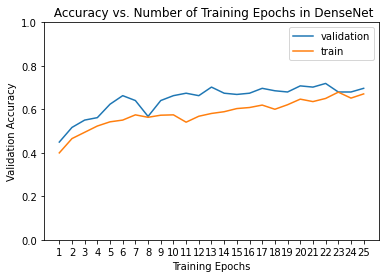

In [53]:
ohist = [h.cpu().numpy() for h in val_histdense]
shist = [h.cpu().numpy() for h in train_histdense]


plt.title(" Accuracy vs. Number of Training Epochs in DenseNet")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="validation")
plt.plot(range(1,num_epochs+1),shist,label="train")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

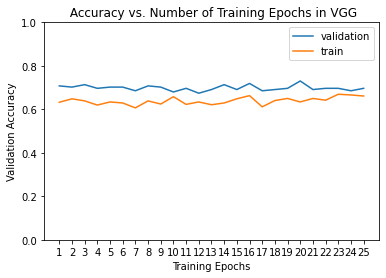

In [54]:
ohist = [h.cpu().numpy() for h in val_histvgg]
shist = [h.cpu().numpy() for h in train_histvgg]


plt.title(" Accuracy vs. Number of Training Epochs in VGG")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="validation")
plt.plot(range(1,num_epochs+1),shist,label="train")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

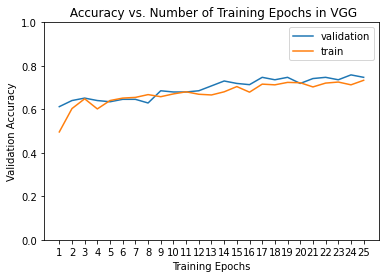

In [47]:
ohist = [h.cpu().numpy() for h in val_histvggnight]
shist = [h.cpu().numpy() for h in train_histvggnight]


plt.title(" Accuracy vs. Number of Training Epochs in VGG")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="validation")
plt.plot(range(1,num_epochs+1),shist,label="train")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

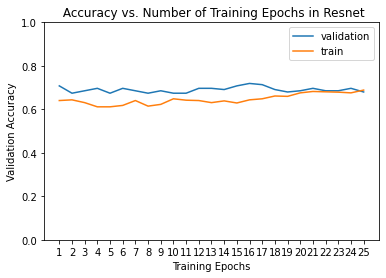

In [67]:
ohist = [h.cpu().numpy() for h in val_histresnet]
shist = [h.cpu().numpy() for h in train_histresnet]


plt.title(" Accuracy vs. Number of Training Epochs in Resnet")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="validation")
plt.plot(range(1,num_epochs+1),shist,label="train")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

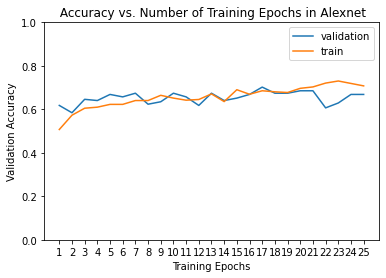

In [77]:
ohist = [h.cpu().numpy() for h in val_histalexnet]
shist = [h.cpu().numpy() for h in train_histalexnet]


plt.title(" Accuracy vs. Number of Training Epochs in Alexnet")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="validation")
plt.plot(range(1,num_epochs+1),shist,label="train")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()